In [ ]:
# import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
import h5py
import json

def fix_model_h5_file(input_file, output_file):
    with h5py.File(input_file, 'r') as f:
        # Load model config (no .decode needed)
        model_config = json.loads(f.attrs['model_config'])
        layers = model_config['config']['layers']

        # Fix layer names
        for layer in layers:
            if 'name' in layer['config'] and '/' in layer['config']['name']:
                original_name = layer['config']['name']
                fixed_name = original_name.replace('/', '_')
                layer['config']['name'] = fixed_name
                print(f"Renamed layer: {original_name} -> {fixed_name}")

        # Update the model config
        fixed_model_config = json.dumps(model_config)

    # Save the fixed model
    with h5py.File(output_file, 'w') as f_fixed:
        # Copy weights from the original file
        with h5py.File(input_file, 'r') as f:
            for key in f.keys():
                f.copy(key, f_fixed)
        # Update the model configuration
        f_fixed.attrs['model_config'] = fixed_model_config
        print("Model file updated and saved.")

# Fix the problematic model file
fix_model_h5_file('model.h5', 'fixed_model.h5')


Renamed layer: conv1/conv -> conv1_conv
Renamed layer: conv1/bn -> conv1_bn
Renamed layer: conv1/relu -> conv1_relu
Model file updated and saved.


In [26]:
from keras.models import load_model

# Load the model
model = load_model('fixed_model.h5')

# Save the configuration and weights separately
model_config = model.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(model_config)

model.save_weights('model.weights.h5')

In [30]:
test_df = pd.read_csv("./dataset/split-data/train_new.csv")
testgen = ImageDataGenerator(rescale=1./255)
test_generator = testgen.flow_from_dataframe(
    dataframe=test_df,
    directory="./dataset/img",
    x_col="img_path",
    y_col="category",
    target_size=(256, 256),
    batch_size=128,
    class_mode="categorical",
    workers=4
)

Found 7339 validated image filenames belonging to 46 classes.


In [32]:
# remove the last layer
model = Model(inputs=model.input, outputs=model.layers[-2].output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy, top_k_categorical_accuracy'])

# save all the features for the test data
features = model.predict(test_generator)


C:\Users\Paolo Canigiula\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 765s 13s/step


In [36]:
# test using the first element of test_generator
import random

feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Initialize arrays for storing features, inputs, and labels
features = []
inputs = []
labels = []


total_batches = len(test_generator)
print(total_batches)
# random_batch_indices = random.sample(range(total_batches), 300)
print(len(test_generator))

batch_index = 0

for batch_x, batch_y in test_generator:
    batch_index += 10

    if batch_index % 50 != 0:
        continue
    print("Processing batch:", batch_index)
    # Stop when we've processed all batches
    print("one loop")
    batch_features = feature_extractor.predict(batch_x)
    
    # Append features, inputs, and labels
    features.append(batch_features)
    inputs.append(batch_x)
    labels.append(batch_y)
    
    #stop when len(features) reaches 30
    if len(features) >= 10:
        break

image_paths = test_df["img_path"].values

# Convert lists to NumPy arrays
features = np.concatenate(features, axis=0)
inputs = np.concatenate(inputs, axis=0)
labels = np.concatenate(labels, axis=0)

# Save features, inputs, and labels to a file
data_to_save = {
    'features': features,
    'inputs': inputs,
    'labels': labels,
    'paths': image_paths
}
np.save('clothing_features_with_paths.npy', data_to_save)
np.set_printoptions(threshold=1000) 
print("Features shape:", features.shape)
print("First feature vector:", features[0])



58
58
Processing batch: 50
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step
Processing batch: 100
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
Processing batch: 150
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Processing batch: 200
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
Processing batch: 250
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
Processing batch: 300
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Processing batch: 350
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Processing batch: 400
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Processing batch: 450
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
Processing batch: 500
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Features shape: (1280, 1024)
First feature vector: [4.2270584e-04 2.6337025e-03 2.8178173e-03 ... 6.4261484e-01 7.8301504e-02
 1.5077335e-01]


In [56]:
!pip install faiss-cpu

In [38]:
import numpy as np

features = features.astype('float32')

np.save('faiss_features.npy', features)
np.save('faiss_inputs.npy', inputs)
np.save('faiss_labels.npy', labels)

print("Features and metadata saved for Faiss.")


Features and metadata saved for Faiss.


In [40]:
# Example: If the feature vector dimensionality is known (e.g., 1024)
d = 1024
n_samples = features.size // d

# Reshape the 1D array into 2D
features = features.reshape(n_samples, d)
print("Reshaped features:", features.shape)

print("Features shape:", features.shape)
print("Features data:", features)  # Print some data to confirm
print("Original features list length:", len(features))
print("Shape of first batch in features list:", features[0].shape)  # Shape of individual batch


Reshaped features: (1280, 1024)
Features shape: (1280, 1024)
Features data: [[4.22705838e-04 2.63370248e-03 2.81781727e-03 ... 6.42614841e-01
  7.83015043e-02 1.50773346e-01]
 [1.57137591e-04 2.22004717e-03 4.67347074e-03 ... 8.85937870e-01
  5.17713785e-01 7.16676712e-02]
 [5.22894319e-04 2.73222616e-03 4.25607990e-03 ... 1.31948262e-01
  1.22066006e-01 1.01165867e+00]
 ...
 [4.69441555e-04 3.42909293e-03 5.06825838e-03 ... 4.59442705e-01
  1.34897064e-02 5.20047903e-01]
 [3.78068013e-04 4.55600768e-03 3.53116100e-03 ... 2.89690197e-02
  2.71299541e-01 9.71578479e-01]
 [3.72477749e-04 2.49885465e-03 3.13561363e-03 ... 2.39220119e+00
  4.71160263e-02 5.65969467e-01]]
Original features list length: 1280
Shape of first batch in features list: (1024,)


In [42]:
import faiss

# Load saved features
saved_data = np.load('clothing_features_with_paths.npy', allow_pickle=True).item()
features = saved_data['features']
image_paths = saved_data['paths']

# Get dimensionality of features
d = features.shape[1]  # Feature vector dimension

# Create Faiss index (using L2 distance for exact search)
index = faiss.IndexFlatL2(d)
index.add(features)  # Add feature vectors to the index

print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 1280


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from matplotlib import pyplot as plt


# Load and preprocess the new input image
new_input_path = "./dataset/img_for_rec/IMG_5606.jpeg"    # Replace with your image path
img = load_img(new_input_path, target_size=(256, 256))  # Resize to match `target_size`
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, H, W, C)

# Create an ImageDataGenerator for preprocessing
inputgen = ImageDataGenerator(rescale=1./255)

# Preprocess the new input
new_input_generator = inputgen.flow(img_array, batch_size=1)



Shape of labels: (1280,)
Shape of features: (1280, 1024)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Shape of labels after conversion: (1280,)


ValueError: 'c' argument has 1310720 elements, which is inconsistent with 'x' and 'y' with size 1280.

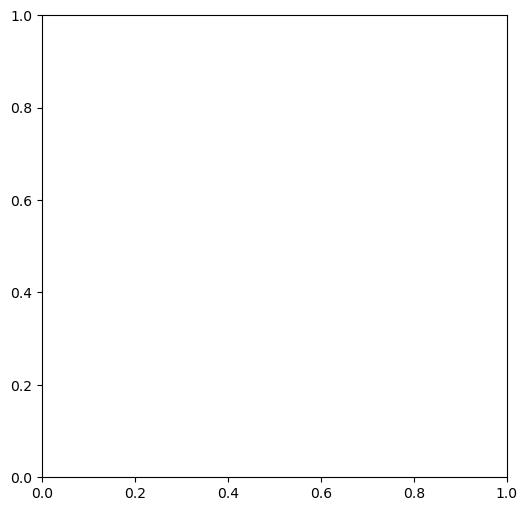

In [84]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Shape of labels:", labels.shape)  # Should be (2560,)
print("Shape of features:", features.shape)  # Should be (2560, 1024)
print("Unique labels:", np.unique(labels))

print("Shape of labels after conversion:", labels.shape)

# Reduce embedding dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=50)
reduced_embeddings = tsne.fit_transform(features)

# Plot the embeddings with labels
plt.figure(figsize=(6, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("2D Visualization of Embedding Space")
plt.show()

In [111]:
from IPython.display import display, Image
import random

random_index = random.randint(0, 1280) # should be number of image paths
random_image_path = image_paths[random_index]
#labels = np.argmax(labels, axis=1)

original_label = labels[random_index]
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
new_input_features = feature_extractor.predict(new_input_generator)
random_features = features[random_index].reshape(1, -1)

print("Extracted feature vector:", new_input_features)
print(labels[random_index])



k = 100  # Number of neighbors to retrieve
print("Shape of features[random_index]:", random_features)
print(image_paths[random_index])
distances, indices = index.search(random_features, k)

print("Distances:", distances)
print("Indices:", indices)

similar_image_paths = [image_paths[idx] for idx in indices[0]]
similar_image_labels = [labels[idx] for idx in indices[0]]
original_path = ("./dataset/img/" + random_image_path)
print(similar_image_paths)

# Display the original and similar images
def display_images(original_path, similar_image_paths):
    display(Image(filename = original_path))
    
    for path in similar_image_paths:
        display(Image(filename="./dataset/img/" + path))

def similar_image_score(original_label, similar_image_labels):
    print("Original Label Category: " + str(original_label))  # Convert integer to string
    print(str(similar_image_labels))

    hits = 0
    for label in similar_image_labels:
        if original_label == label:  # Compare directly, no need for indexing
            hits += 1
        
    print("Number of recommended images in the same category: " + str(hits) + " out of "+ str(k) + " images")
    print("% categorically accurate : " + str(hits/k))

#display_images(original_path, similar_image_paths)
similar_image_score(original_label, similar_image_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Extracted feature vector: [[0.00039874 0.00414509 0.00655918 ... 0.37406015 0.00655346 0.00411823]]
28
Shape of features[random_index]: [[5.7101308e-04 2.0826862e-03 3.2568020e-03 ... 9.7154692e-02
  1.8454842e-01 9.4498086e-01]]
img/Zip_Collar_Bomber/img_00000015.jpg
Distances: [[  0.      334.85858 339.44626 347.26233 347.57147 347.87296 354.1346
  354.8427  355.92914 356.1629  363.07626 363.49536 369.8474  370.2353
  371.6496  371.67645 371.97006 372.54858 373.166   373.80005 375.63153
  375.64383 375.71503 375.86374 378.34277 379.91516 381.7002  381.81873
  383.15674 383.2425  384.1795  384.35443 384.4872  384.7363  387.34964
  388.0191  388.39157 389.31866 389.58905 389.90915 391.60648 391.90253
  392.0468  392.84402 392.8498  393.1496  393.33847 393.4428  393.75293
  394.35175 394.35175 394.74182 394.90012 395.0121  395.5307  396.1775
  397.3368  397.84103 398.2111  398.30817 398.67523 399.07086 399.52948
  399.90396 400.1886  400.75214 400.7